     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 43.9 MB/s eta 0:00:00




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



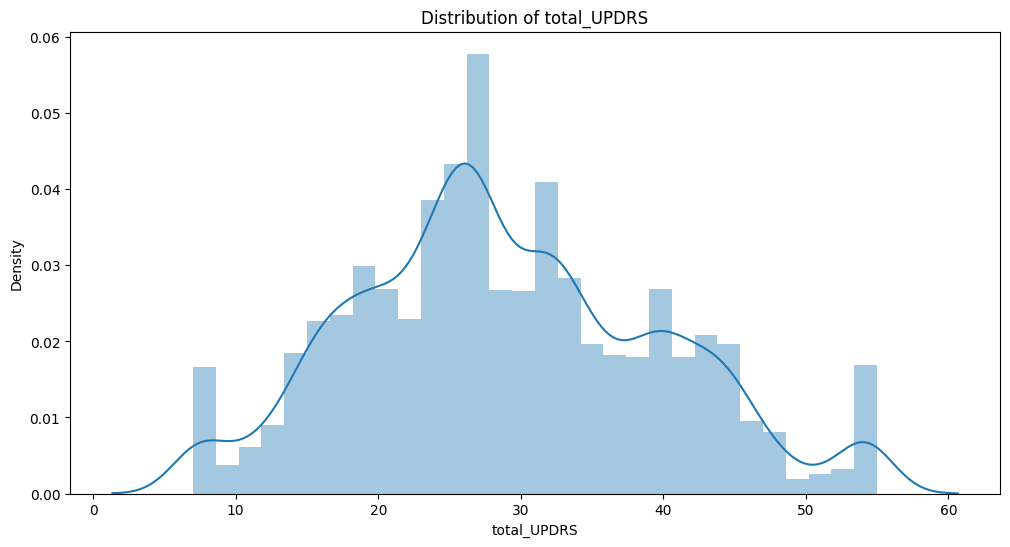

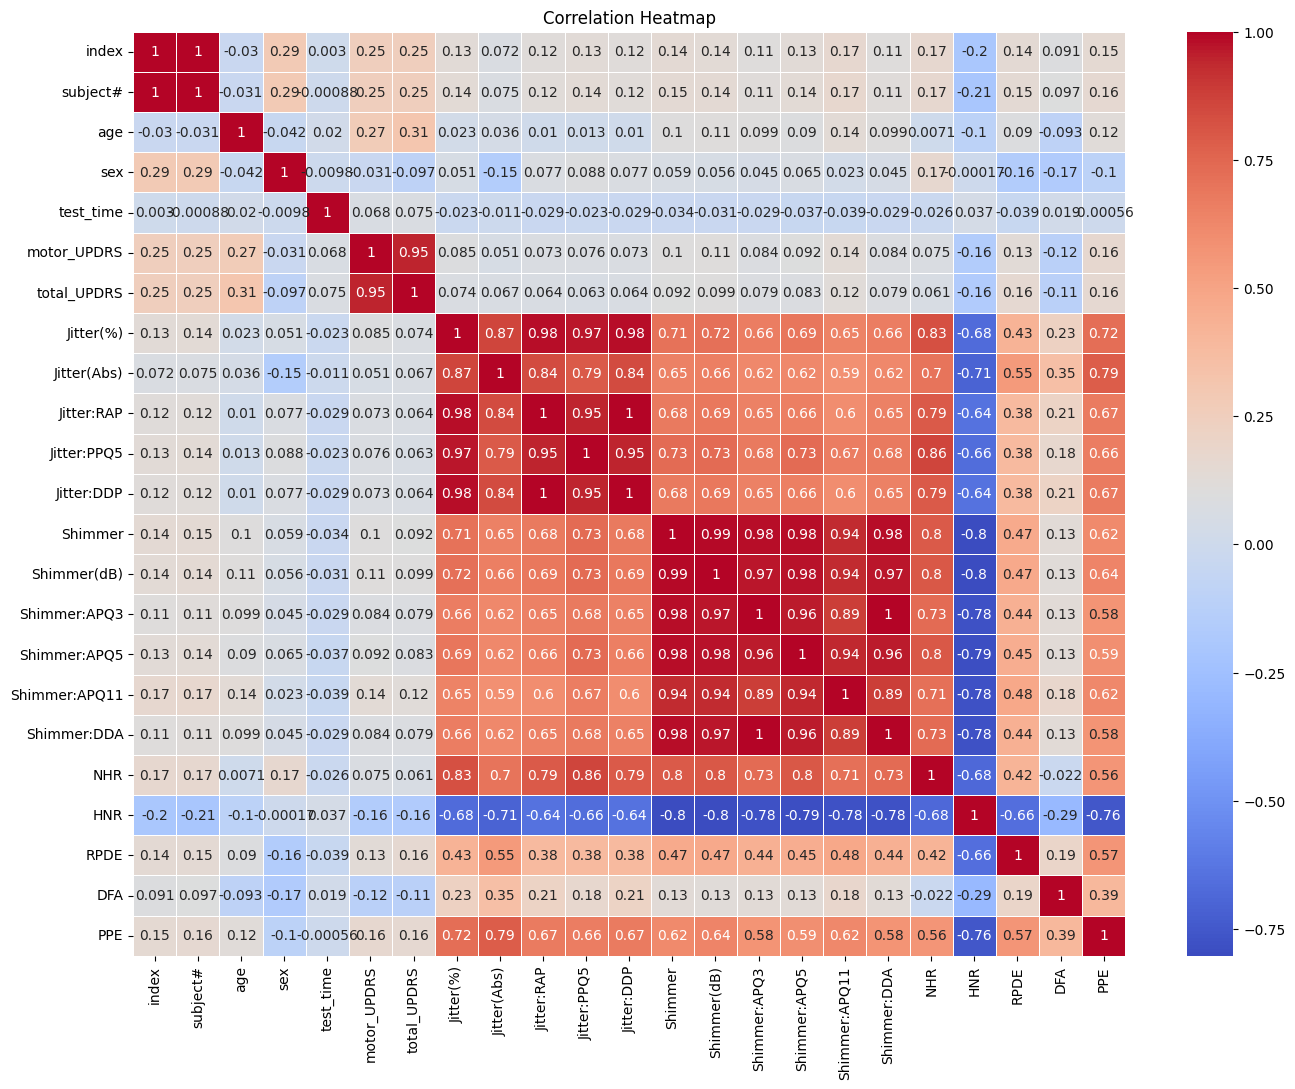

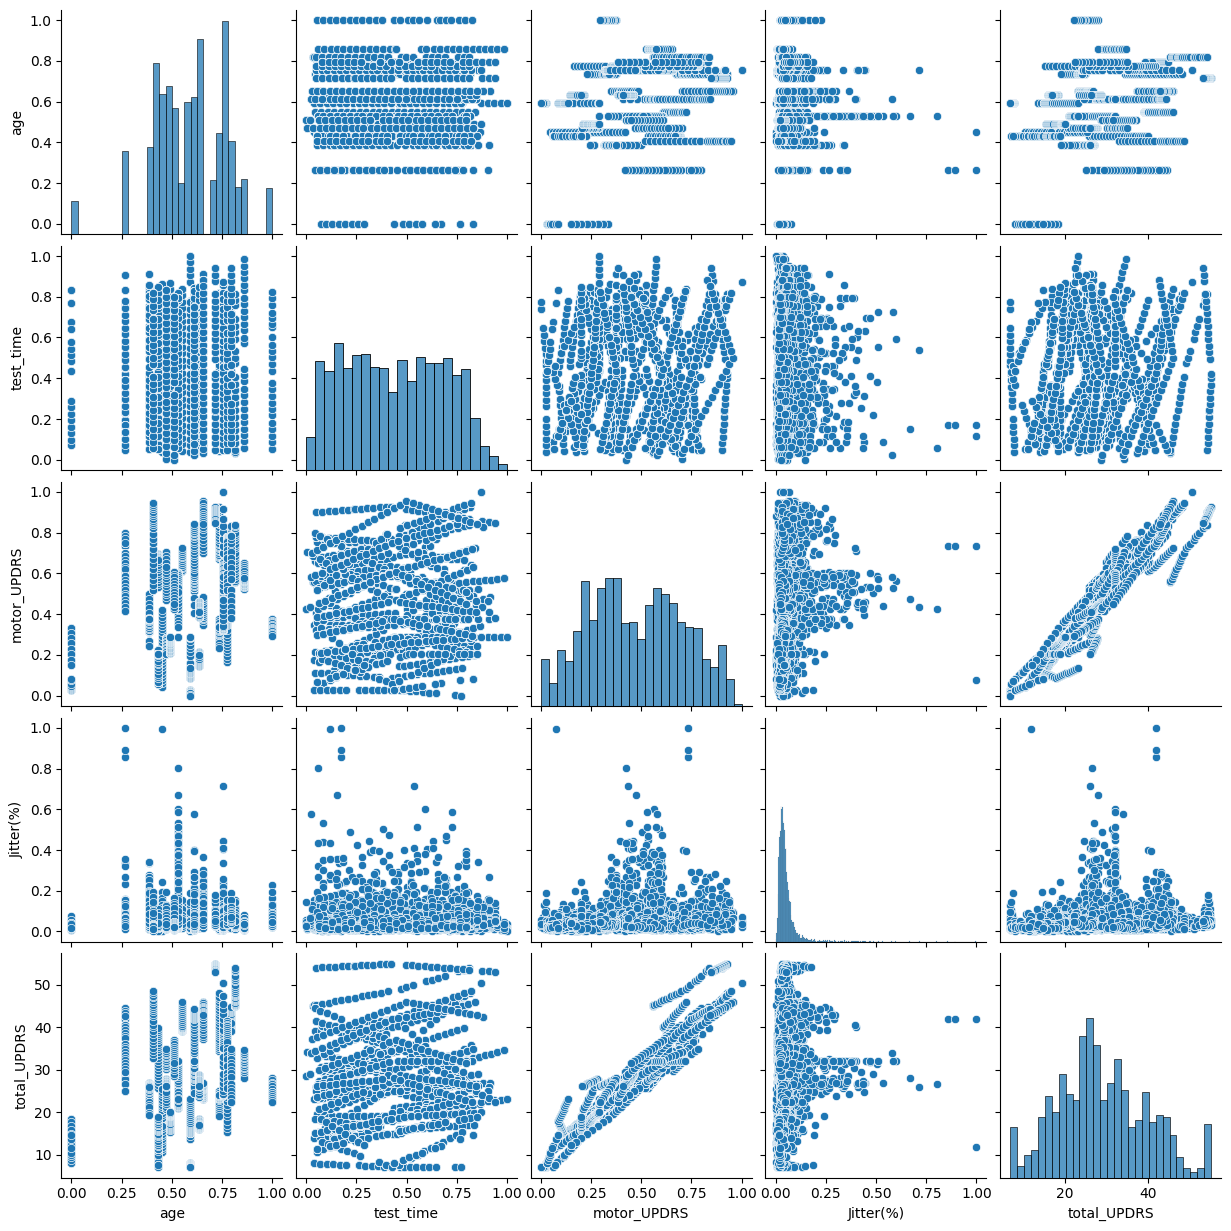

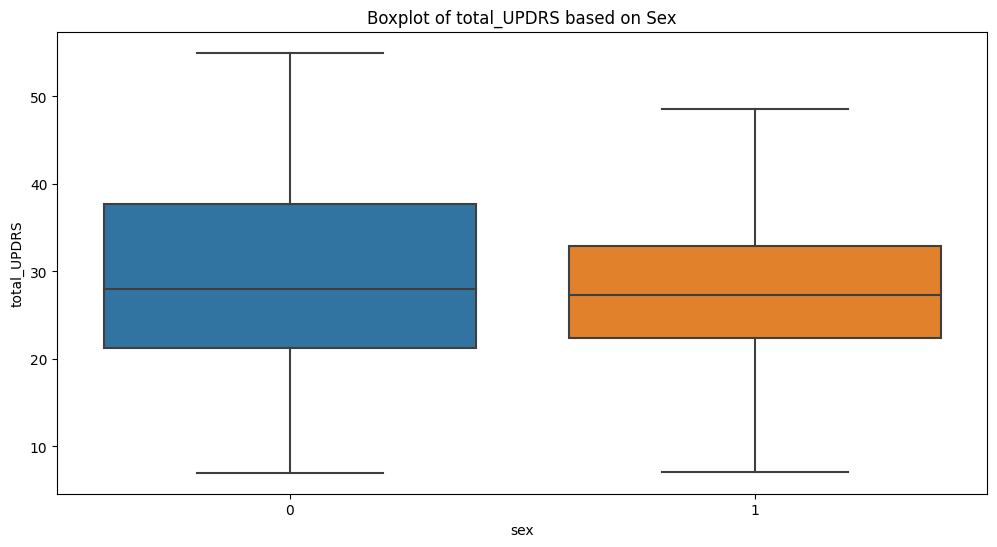

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4913
[LightGBM] [Info] Number of data points in the train set: 4700, number of used features: 22
[LightGBM] [Info] Start training from score 29.076474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4912
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 22
[LightGBM] [Info] Start training from score 29.018407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4912
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 22
[LightGBM] [Info] Start trai

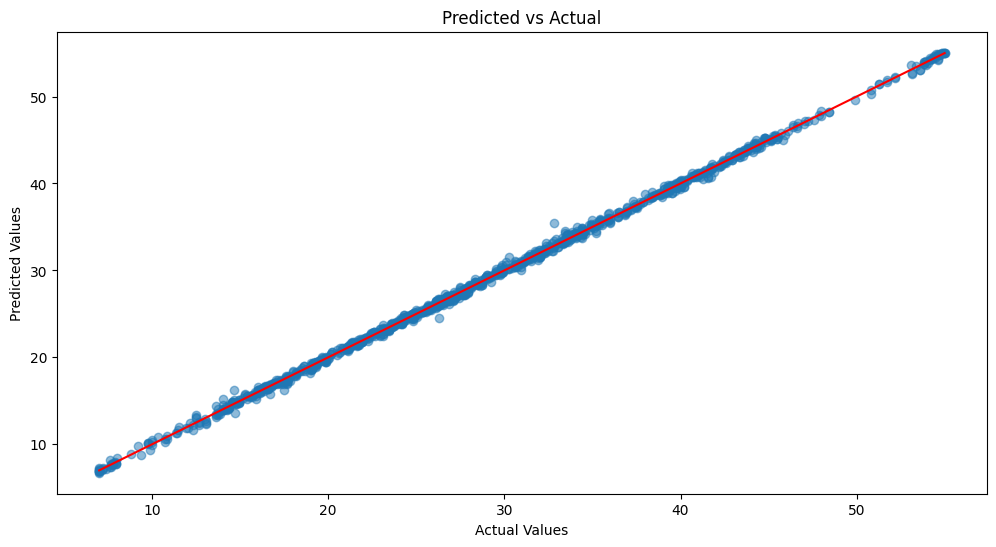

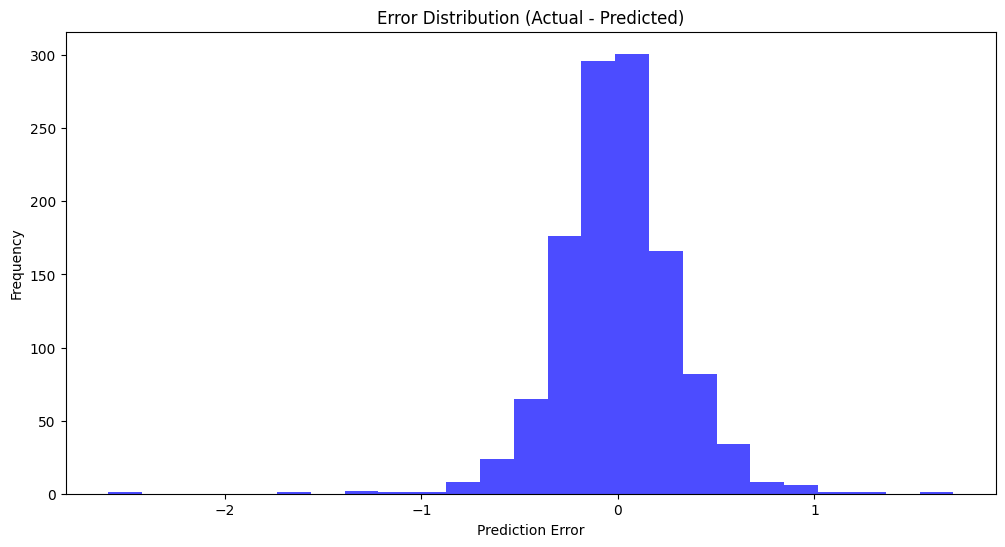

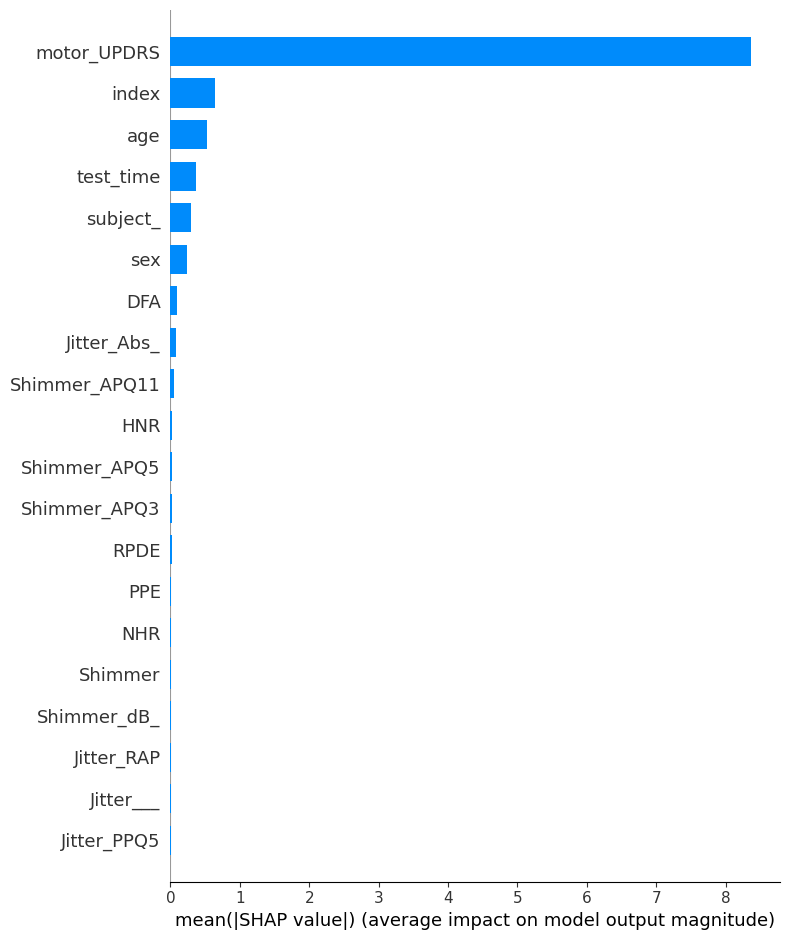

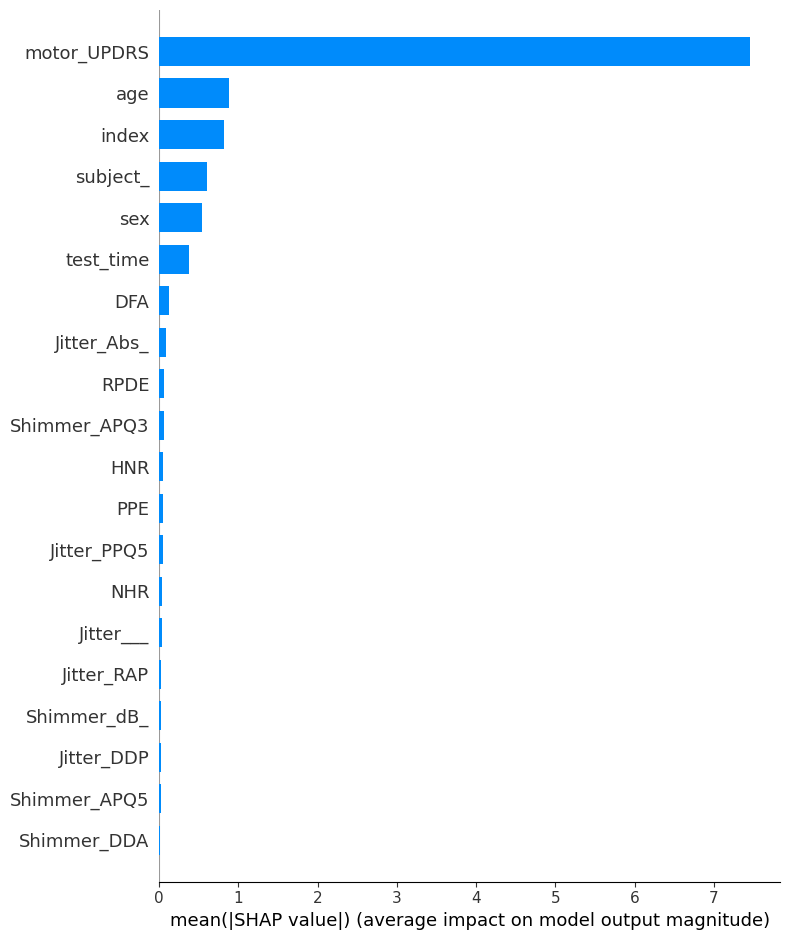

In [1]:
!pip install lightgbm catboost shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap

# Load the dataset
datasetpath = "/content/parkinsons_updrs.data.csv"
data = pd.read_csv(datasetpath)

# Preprocessing
# Handle missing values
for column in data.columns:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].median(), inplace=True)

# Encode 'sex'
data['sex'] = data['sex'].astype('category').cat.codes

# Feature scaling
scaler = MinMaxScaler()
columns_to_scale = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Data Visualization

# Distribution of target variable 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.distplot(data['total_UPDRS'], bins=30)
plt.title('Distribution of total_UPDRS')
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Pairplot of select features
selected_features = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'total_UPDRS']
sns.pairplot(data[selected_features])
plt.show()

# Boxplot for 'sex' vs 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.boxplot(x='sex', y='total_UPDRS', data=data)
plt.title('Boxplot of total_UPDRS based on Sex')
plt.show()

# Splitting the data
X = data.drop(['total_UPDRS'], axis=1)
y = data['total_UPDRS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Rename columns to avoid special characters (for LightGBM and CatBoost)
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = X_train.columns

# Stacked Regression
# Define base learners
base_learners = [
    ('lightgbm', lgb.LGBMRegressor()),
    ('catboost', CatBoostRegressor(verbose=0))  # verbose=0 to silence the output
]

# Define meta learner
meta_learner = LinearRegression()

# Stacking regressor
stacked_reg = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)
stacked_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = stacked_reg.predict(X_test)

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
sse = np.sum((y_test - y_pred) ** 2)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE for Stacked Regression:", rmse)
print("SSE for Stacked Regression:", sse)
print("R-Squared for Stacked Regression:", r2)
print("MAE for Stacked Regression:", mae)

# Plotting Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Plotting Error Function (Difference between Actual and Predicted)
error = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(error, bins=25, alpha=0.7, color='blue')
plt.title("Error Distribution (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

# SHAP Analysis on Base Models
# For LightGBM model
lgb_model = stacked_reg.named_estimators_['lightgbm']
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Visualizing SHAP values for LightGBM model
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar")
plt.show()

# SHAP Analysis on CatBoost Model
catboost_model = stacked_reg.named_estimators_['catboost']
explainer_cb = shap.TreeExplainer(catboost_model)
shap_values_cb = explainer_cb.shap_values(X_test)

# Visualizing SHAP values for CatBoost model
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values_cb, X_test, plot_type="bar")
plt.show()


<ipython-input-3-b188c0a1a132>:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['total_UPDRS'], bins=30)


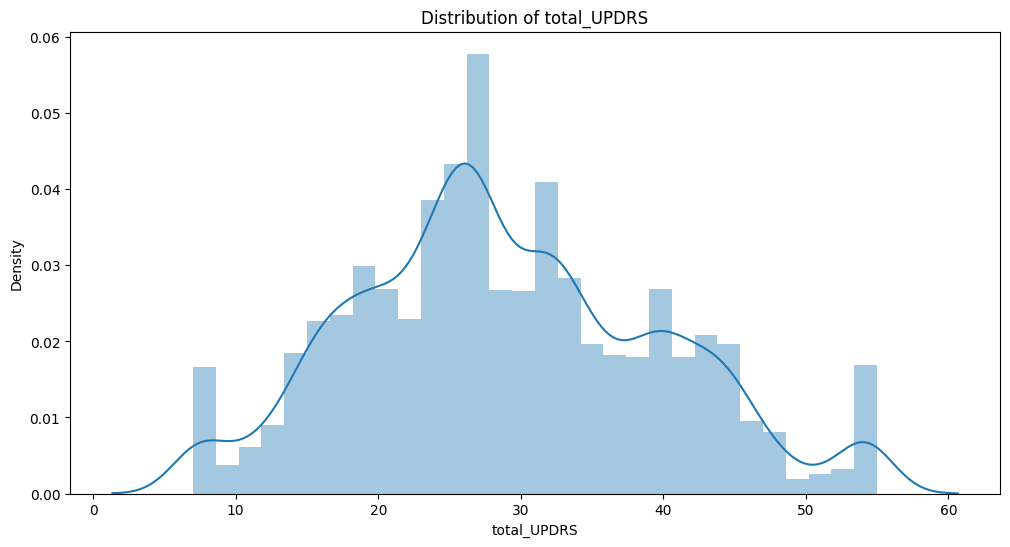

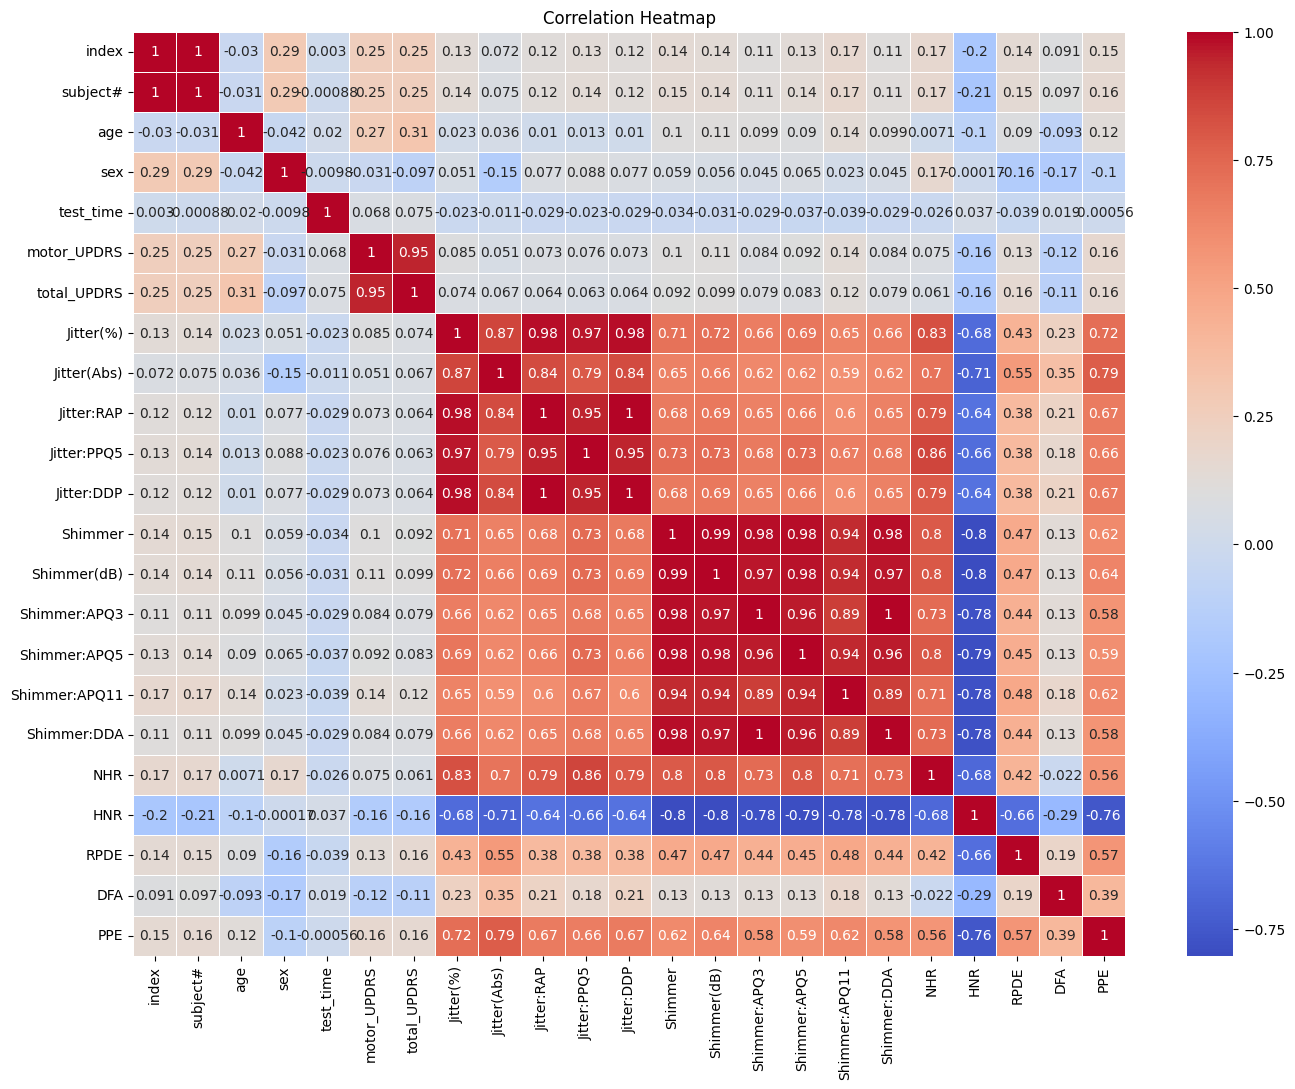

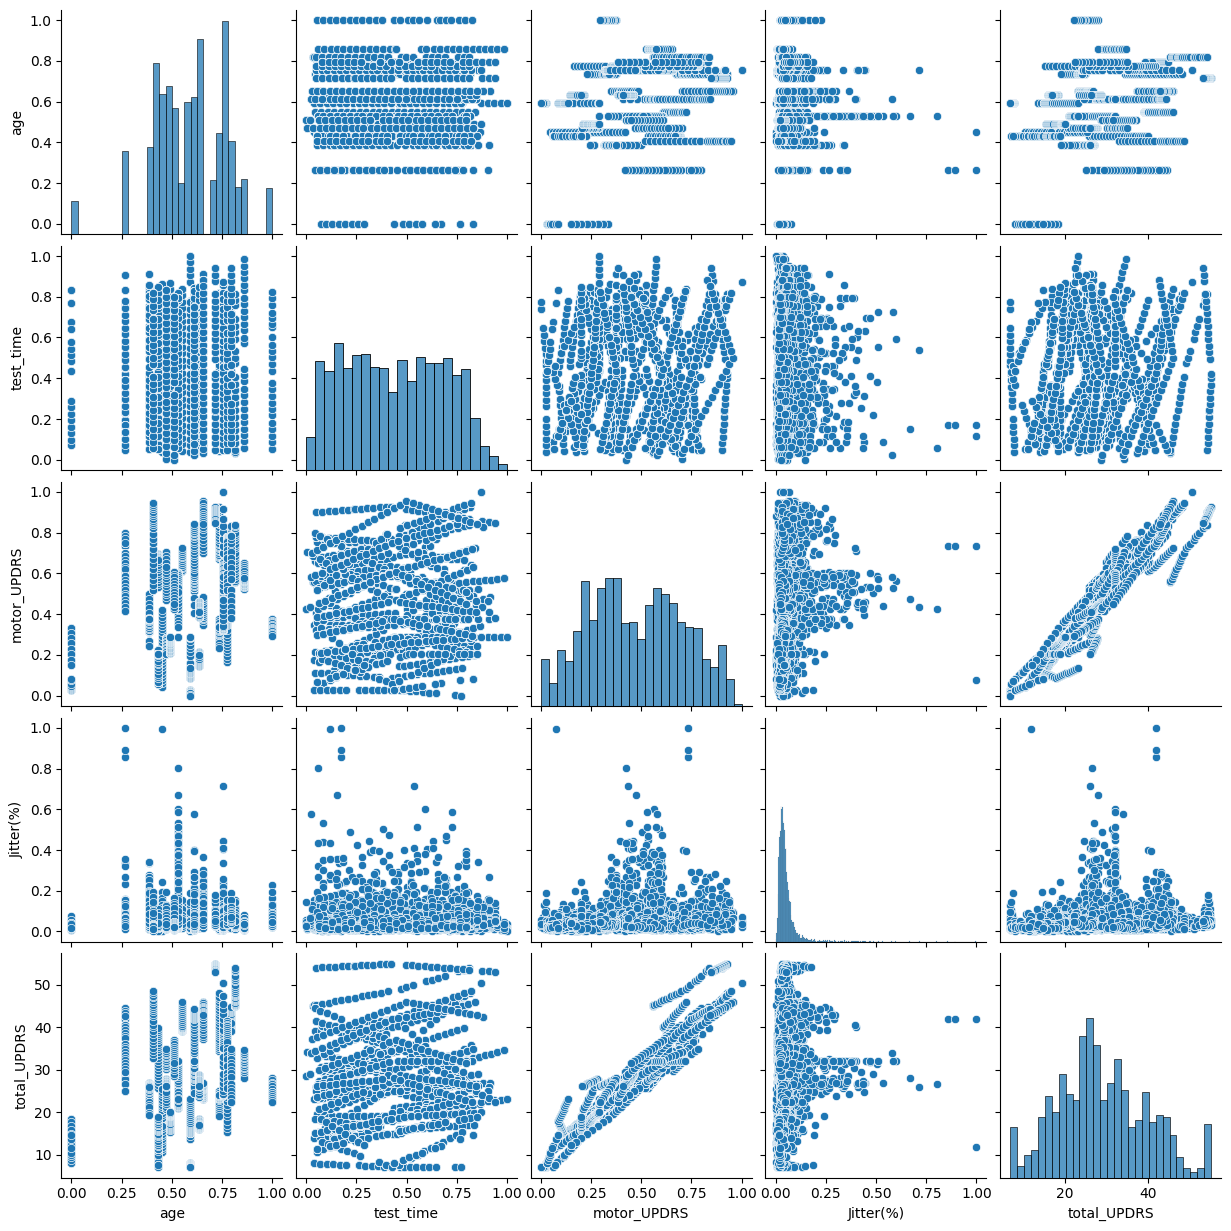

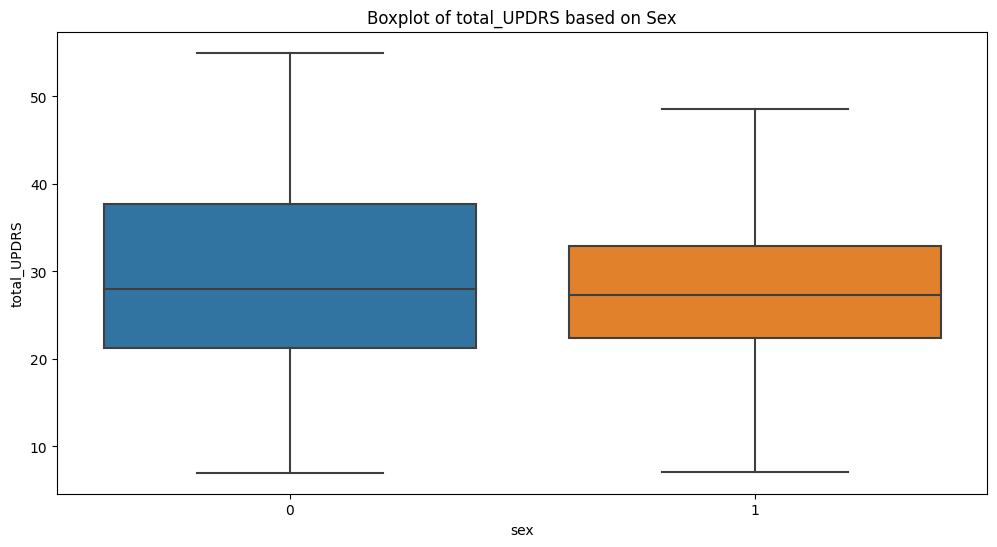

RMSE for KNN Regression: 1.7871060270942505
SSE for KNN Regression: 3752.65384369
R-Squared for KNN Regression: 0.9711789527986591
MAE for KNN Regression: 0.9442932936170212


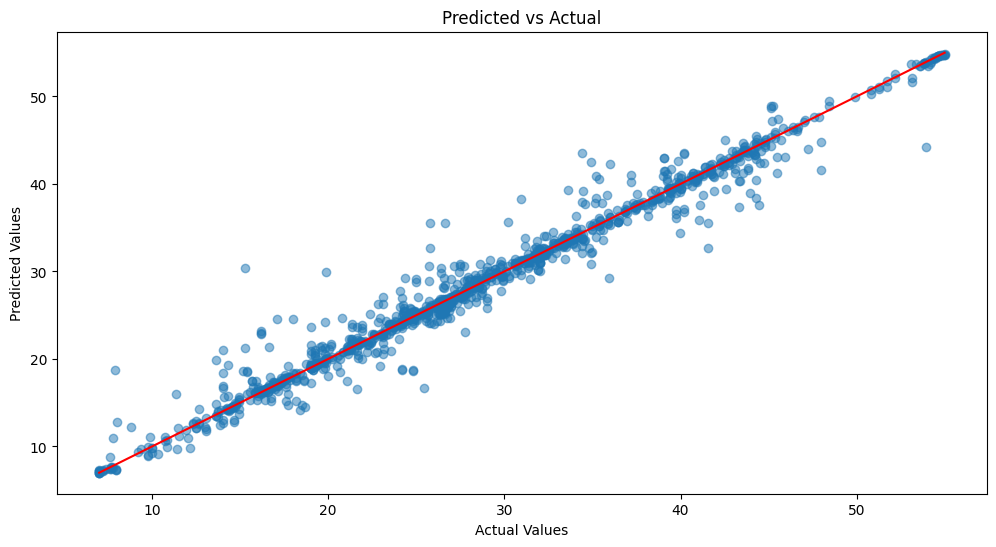

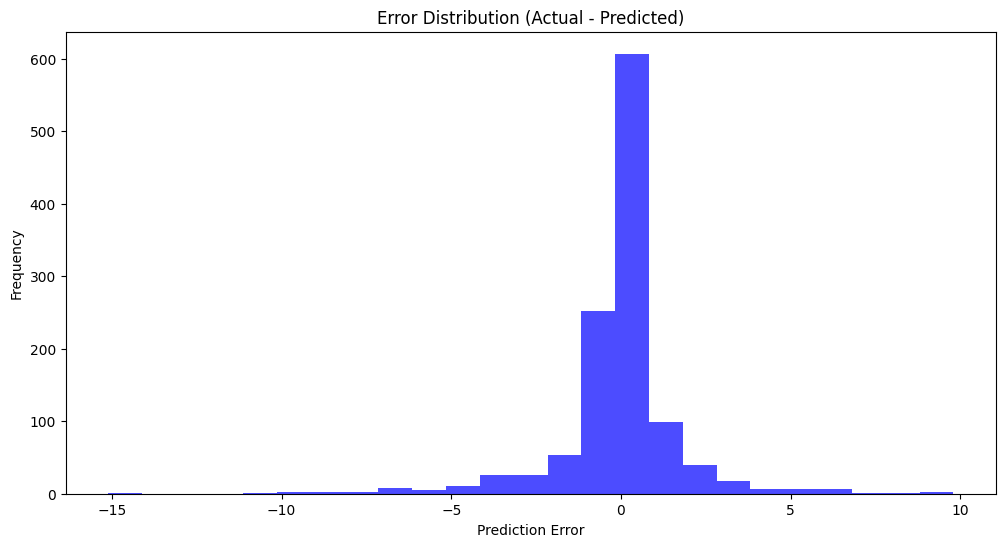

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
datasetpath = "/content/parkinsons_updrs.data.csv"
data = pd.read_csv(datasetpath)

# Preprocessing
# Handle missing values
for column in data.columns:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].median(), inplace=True)

# Encode 'sex'
data['sex'] = data['sex'].astype('category').cat.codes

# Feature scaling
scaler = MinMaxScaler()
columns_to_scale = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Data Visualization
# Distribution of target variable 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.distplot(data['total_UPDRS'], bins=30)
plt.title('Distribution of total_UPDRS')
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Pairplot of select features
selected_features = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'total_UPDRS']
sns.pairplot(data[selected_features])
plt.show()

# Boxplot for 'sex' vs 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.boxplot(x='sex', y='total_UPDRS', data=data)
plt.title('Boxplot of total_UPDRS based on Sex')
plt.show()

# Splitting the data
X = data.drop(['total_UPDRS'], axis=1)
y = data['total_UPDRS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# K-Nearest Neighbors Regression
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn_reg.predict(X_test)

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
sse = np.sum((y_test - y_pred) ** 2)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE for KNN Regression:", rmse)
print("SSE for KNN Regression:", sse)
print("R-Squared for KNN Regression:", r2)
print("MAE for KNN Regression:", mae)

# Plotting Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Plotting Error Function (Difference between Actual and Predicted)
error = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(error, bins=25, alpha=0.7, color='blue')
plt.title("Error Distribution (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

<ipython-input-2-f574e6f39a98>:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['total_UPDRS'], bins=30)


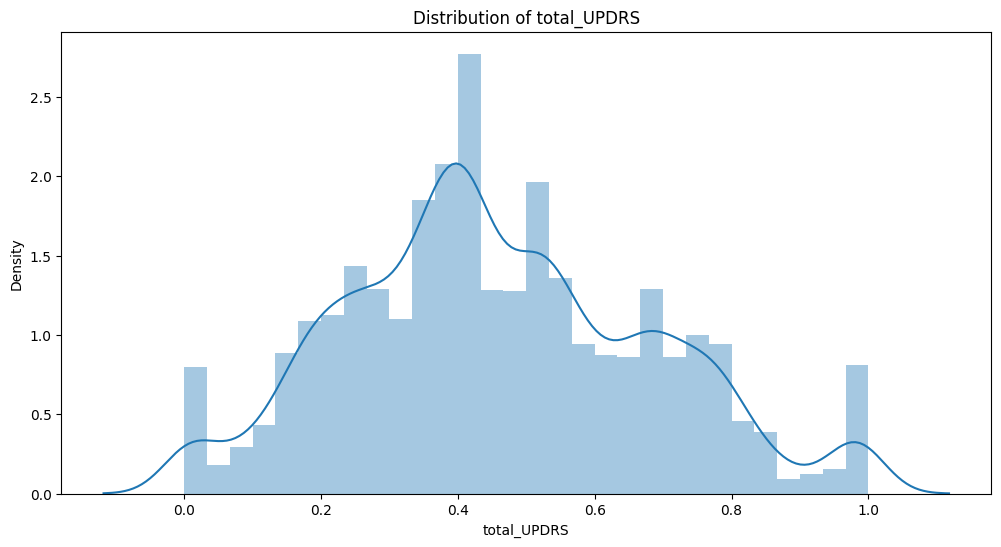

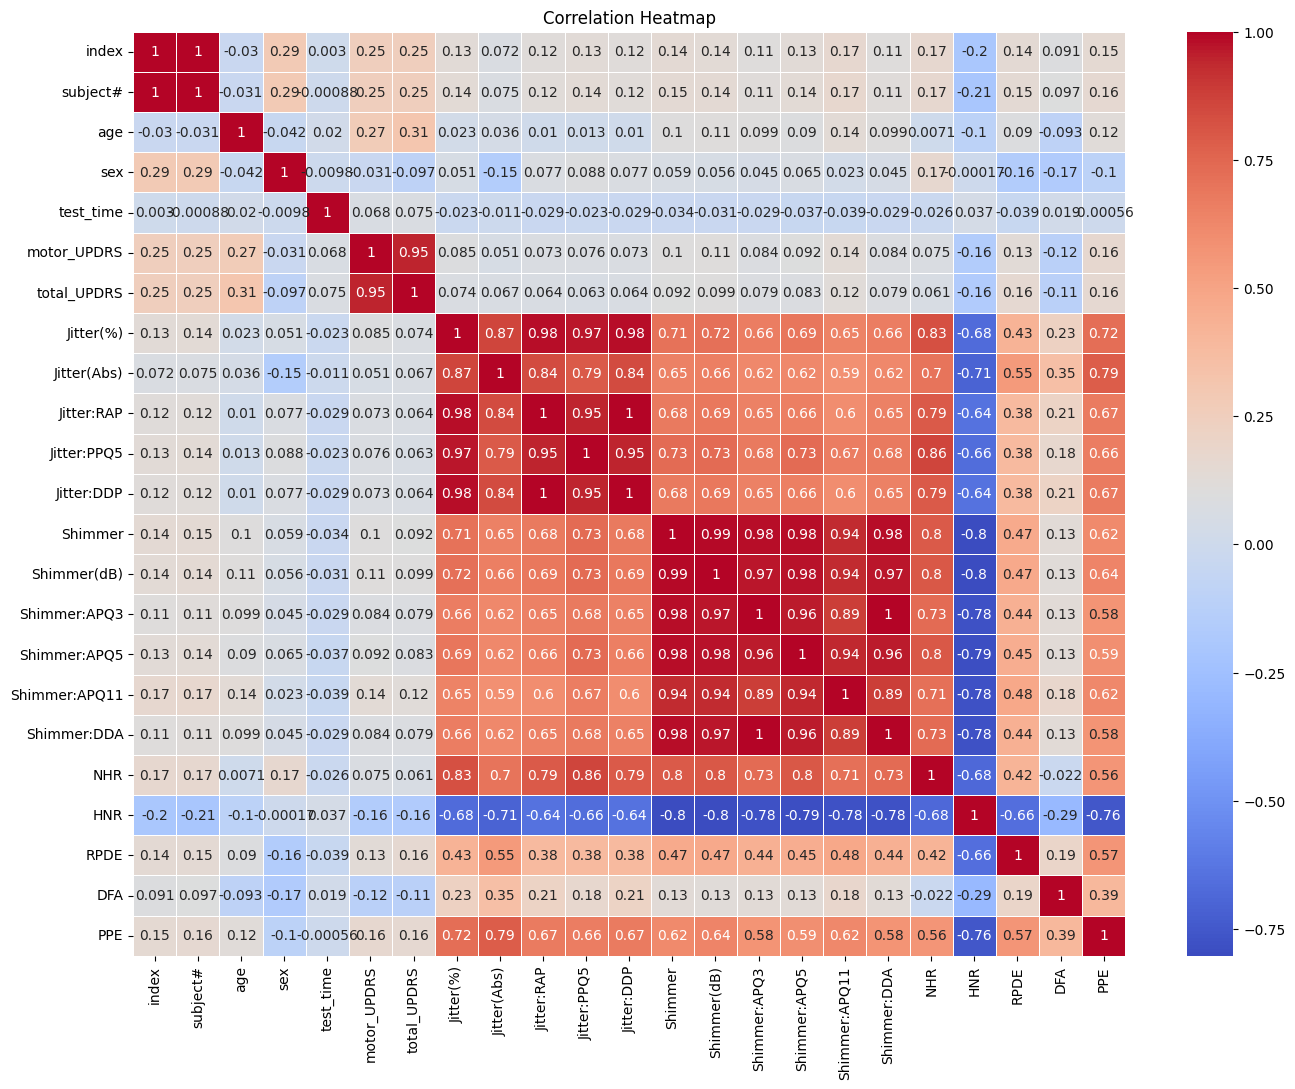

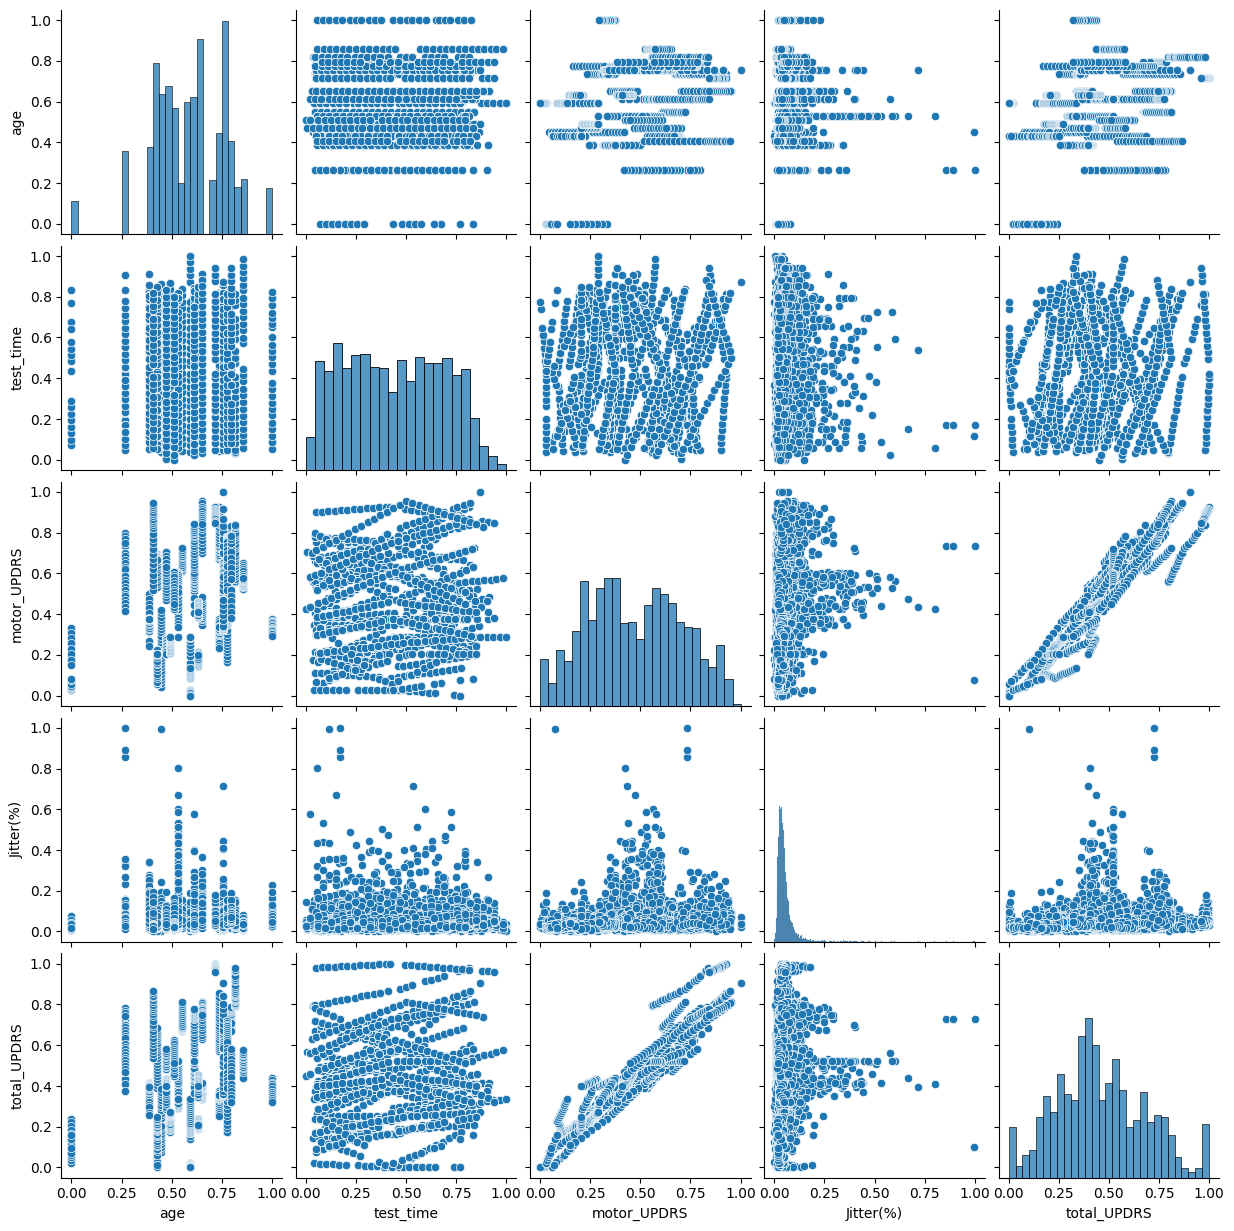

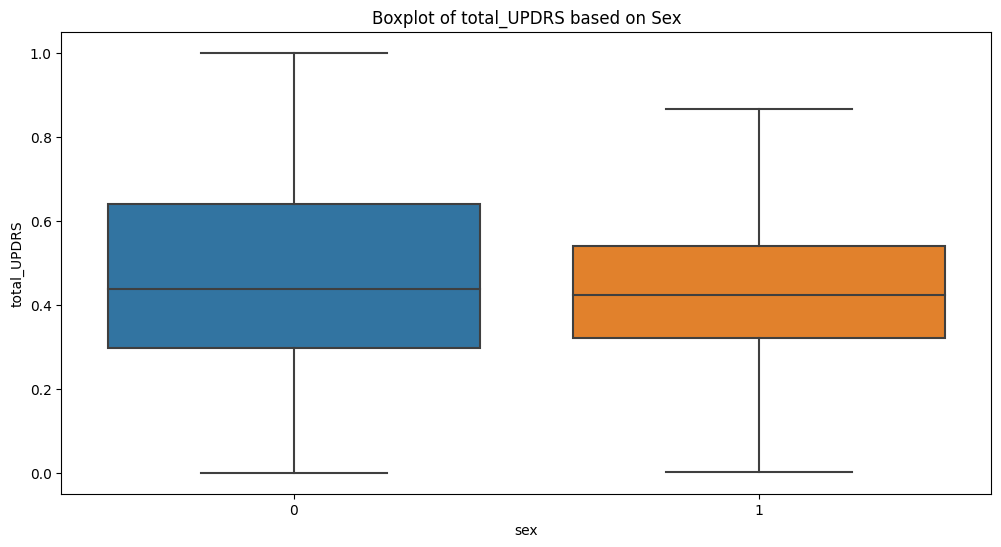

RMSE for SVM Regression: 0.1974983565703243
SSE for SVM Regression: 45.83158099637528
R-Squared for SVM Regression: 0.18927458486570792
MAE for SVM Regression: 0.15383207773539062


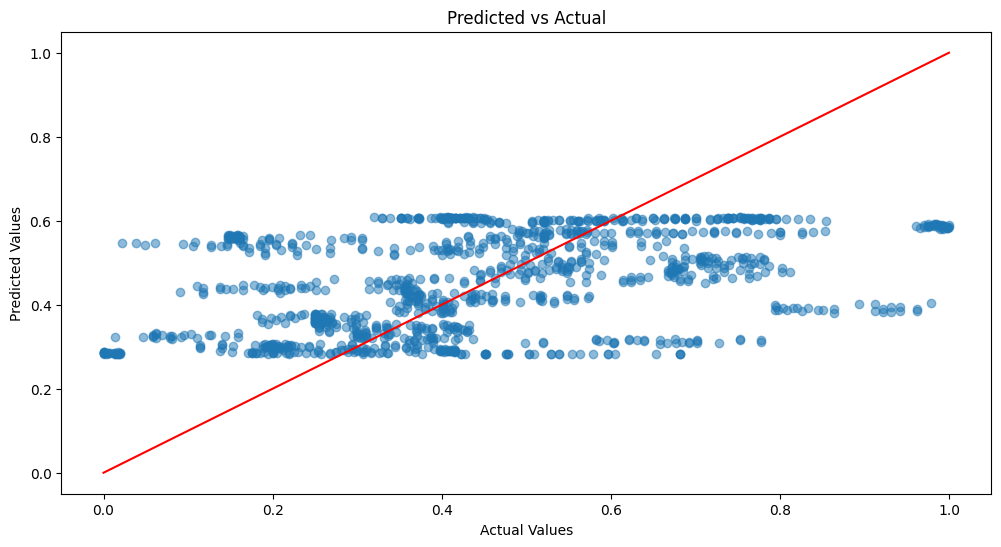

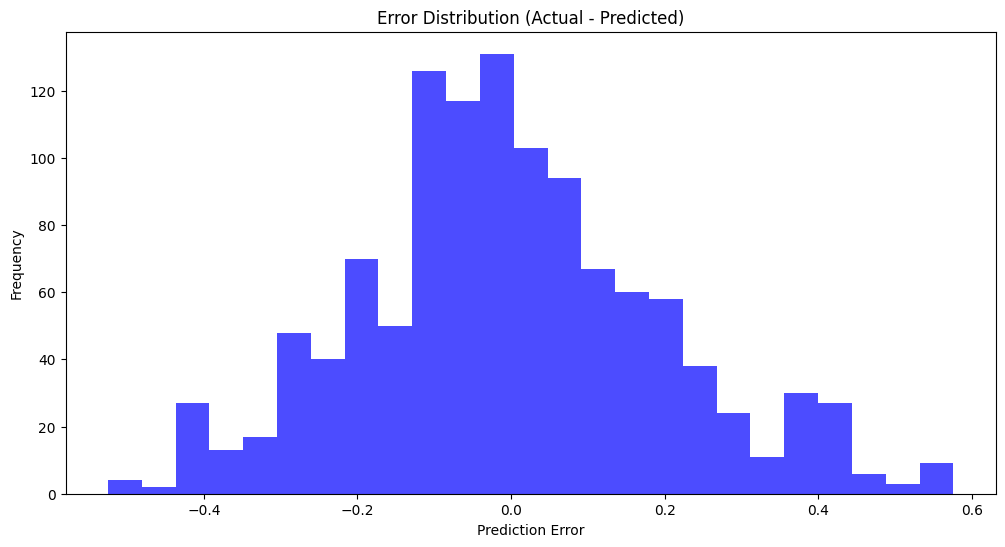

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
datasetpath = "/content/parkinsons_updrs.data.csv"
data = pd.read_csv(datasetpath)

# Preprocessing
# Handle missing values
for column in data.columns:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].median(), inplace=True)

# Encode 'sex'
data['sex'] = data['sex'].astype('category').cat.codes

# Feature scaling
scaler = MinMaxScaler()
columns_to_scale = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'total_UPDRS']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Data Visualization
# Distribution of target variable 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.distplot(data['total_UPDRS'], bins=30)
plt.title('Distribution of total_UPDRS')
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Pairplot of select features
selected_features = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'total_UPDRS']
sns.pairplot(data[selected_features])
plt.show()

# Boxplot for 'sex' vs 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.boxplot(x='sex', y='total_UPDRS', data=data)
plt.title('Boxplot of total_UPDRS based on Sex')
plt.show()

# Splitting the data
X = data.drop(['total_UPDRS'], axis=1)
y = data['total_UPDRS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Support Vector Machine Regression
svm_reg = SVR()
svm_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = svm_reg.predict(X_test)

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
sse = np.sum((y_test - y_pred) ** 2)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE for SVM Regression:", rmse)
print("SSE for SVM Regression:", sse)
print("R-Squared for SVM Regression:", r2)
print("MAE for SVM Regression:", mae)

# Plotting Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Plotting Error Function (Difference between Actual and Predicted)
error = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(error, bins=25, alpha=0.7, color='blue')
plt.title("Error Distribution (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

<ipython-input-1-5373f0b2b6c9>:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['total_UPDRS'], bins=30)


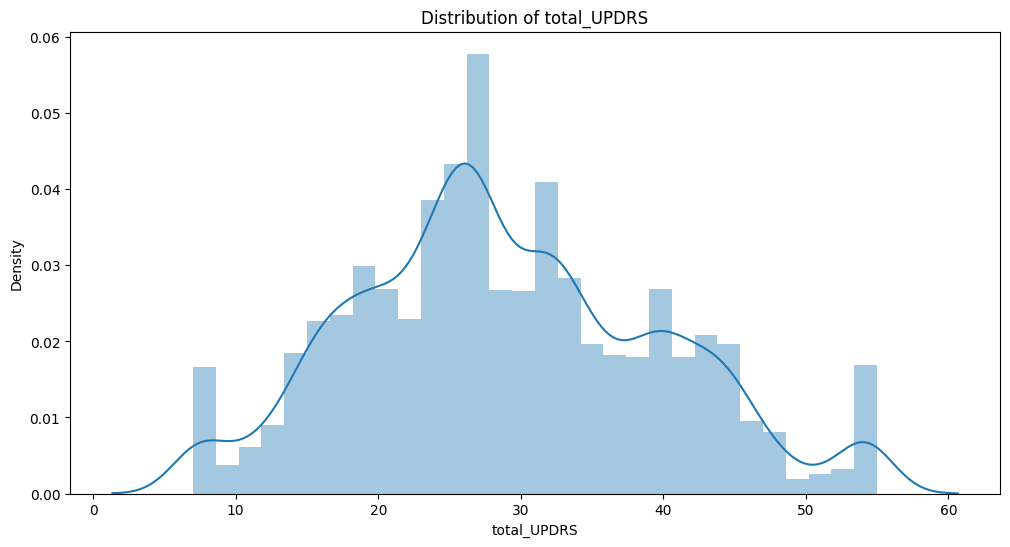

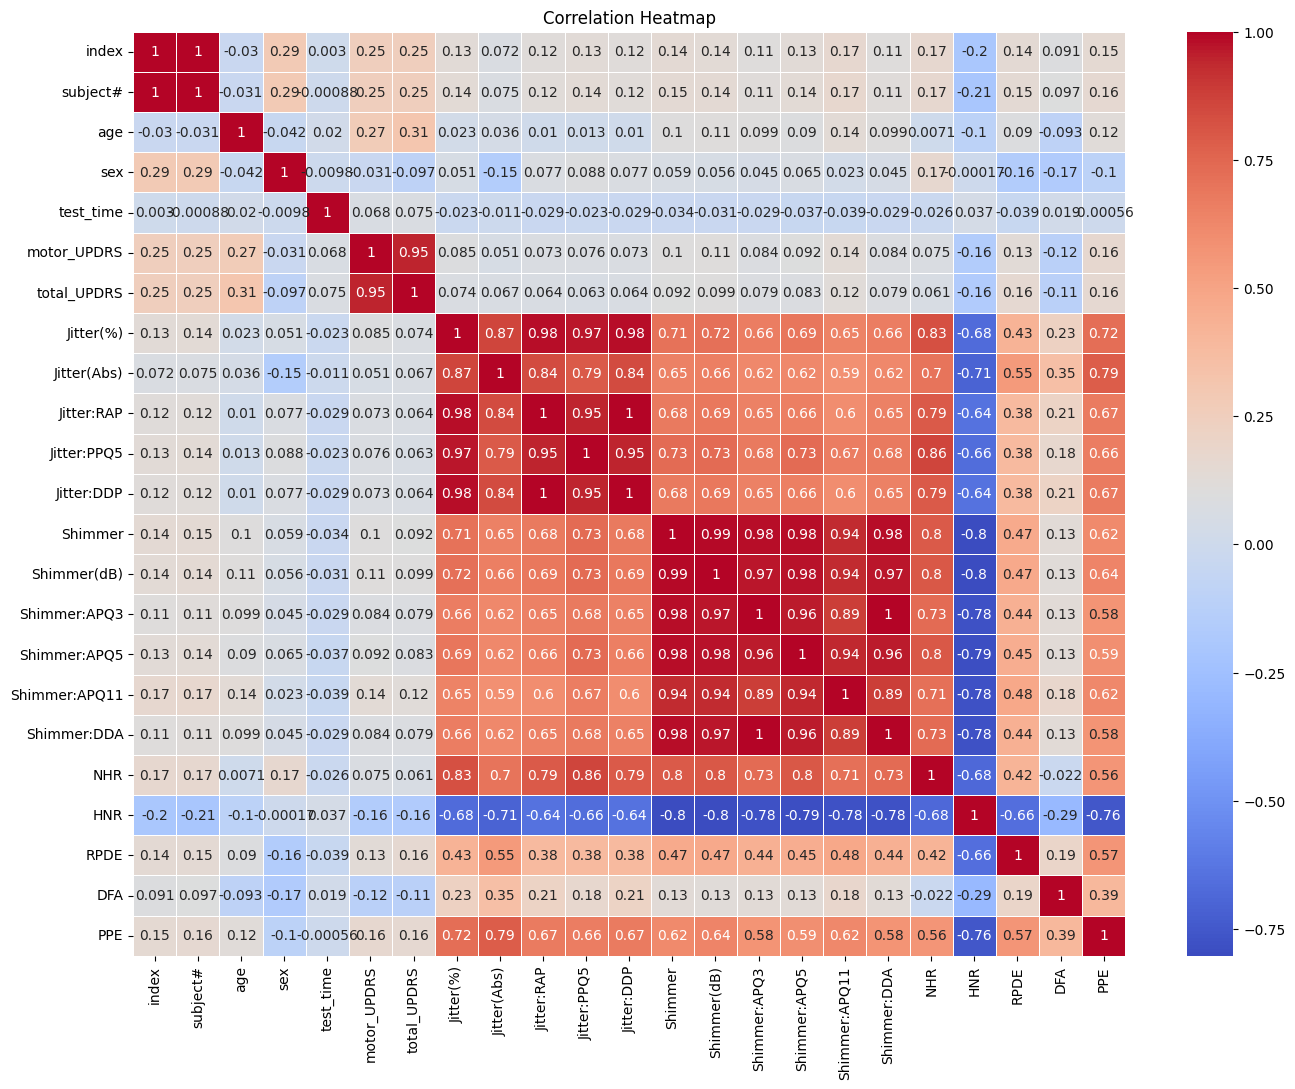

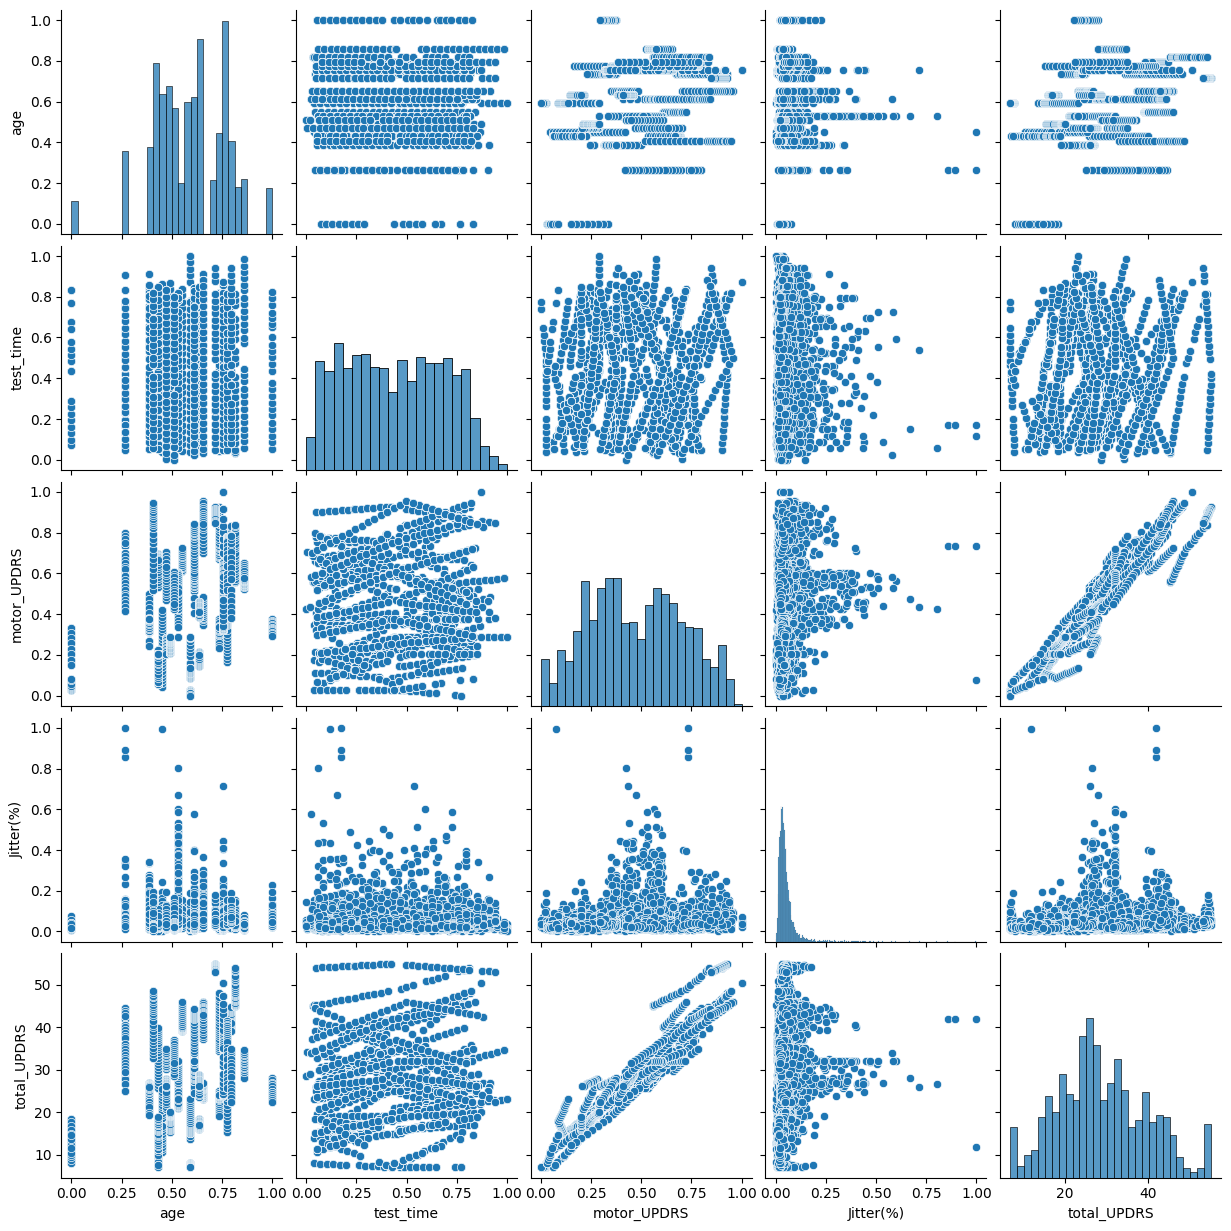

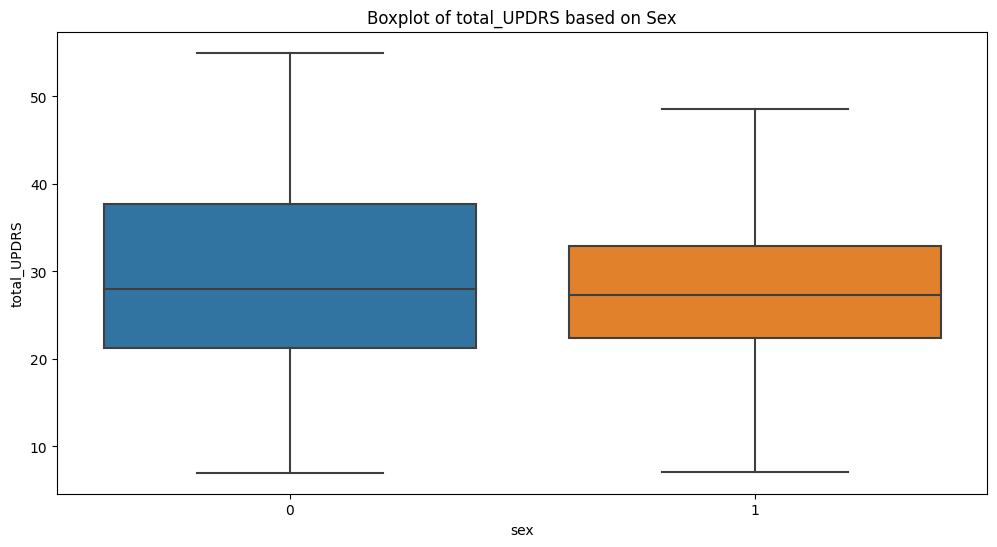

RMSE for XGBoost Regression: 0.34637999207733905
SSE for XGBoost Regression: 140.97544122100953
R-Squared for XGBoost Regression: 0.9989172836038441
MAE for XGBoost Regression: 0.2329413728066303


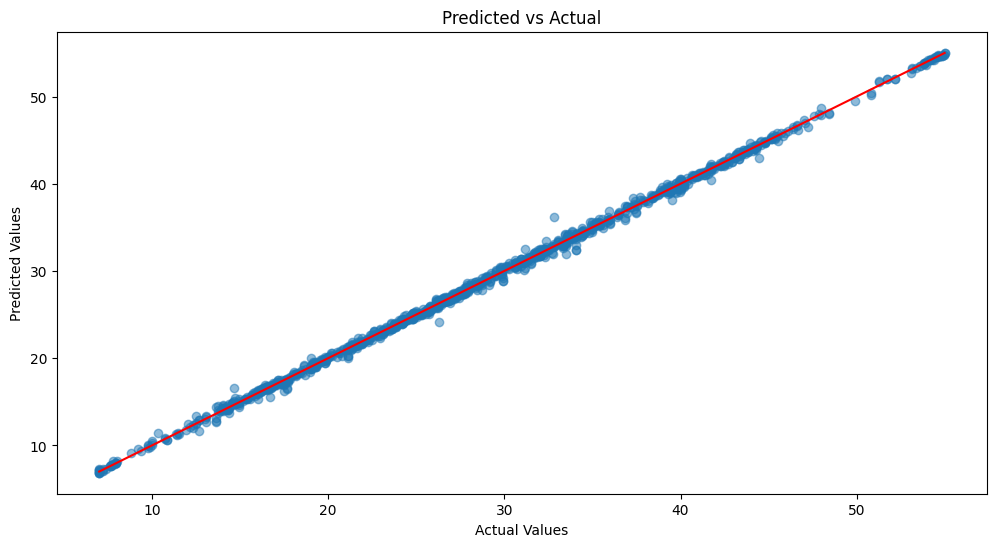

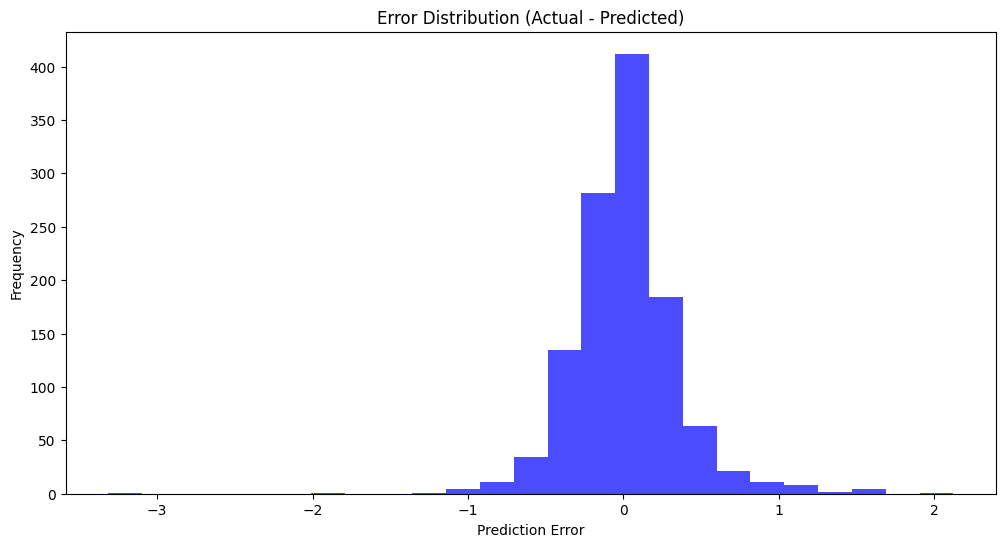

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
datasetpath = "/content/parkinsons_updrs.data.csv"
data = pd.read_csv(datasetpath)

# Preprocessing
# Handle missing values
for column in data.columns:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].median(), inplace=True)

# Encode 'sex'
data['sex'] = data['sex'].astype('category').cat.codes

# Feature scaling
scaler = MinMaxScaler()
columns_to_scale = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Data Visualization
# Distribution of target variable 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.distplot(data['total_UPDRS'], bins=30)
plt.title('Distribution of total_UPDRS')
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Pairplot of select features
selected_features = ['age', 'test_time', 'motor_UPDRS', 'Jitter(%)', 'total_UPDRS']
sns.pairplot(data[selected_features])
plt.show()

# Boxplot for 'sex' vs 'total_UPDRS'
plt.figure(figsize=(12, 6))
sns.boxplot(x='sex', y='total_UPDRS', data=data)
plt.title('Boxplot of total_UPDRS based on Sex')
plt.show()

# Splitting the data
X = data.drop(['total_UPDRS'], axis=1)
y = data['total_UPDRS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regression
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = xg_reg.predict(X_test)

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
sse = np.sum((y_test - y_pred) ** 2)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE for XGBoost Regression:", rmse)
print("SSE for XGBoost Regression:", sse)
print("R-Squared for XGBoost Regression:", r2)
print("MAE for XGBoost Regression:", mae)

# Plotting Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Plotting Error Function (Difference between Actual and Predicted)
error = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(error, bins=25, alpha=0.7, color='blue')
plt.title("Error Distribution (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()
